# 1. Import Packages

In [30]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

from pathlib import Path
from tqdm import tqdm

# 2. Data

In [31]:
# load Fama French Factor Data
factors_df = pd.read_csv(str(Path().absolute()) + "/data/F-F_Research_Data_Factors.CSV", index_col = 0) 
rf = factors_df.loc[:, "RF"]
rf.index = pd.to_datetime(rf.index, format = "%Y%m")

# industry returns
df = pd.read_csv(str(Path().absolute()) + "/data/10_Industry_Portfolios.CSV", index_col = 0, skiprows = 11, nrows = 1182, header=0)
df.index = pd.to_datetime(df.index, format = "%Y%m")
df = df / 100

# remove NAs
df = df.replace(-99.99, np.nan)
df = df.replace(-999, np.nan)

# nb of industries and average sizes dataframes
nb_industries = pd.read_csv(str(Path().absolute()) + "/data/10_Industry_Portfolios.CSV", index_col = 0, skiprows = 2587, nrows = 1182, header=0)
nb_industries.index = pd.to_datetime(nb_industries.index, format = "%Y%m")

avg_size = pd.read_csv(str(Path().absolute()) + "/data/10_Industry_Portfolios.CSV", index_col = 0, skiprows = 3773, nrows = 1182, header=0)
avg_size.index = pd.to_datetime(avg_size.index, format = "%Y%m")

# 3. Portfolio Construction

## 3.1 Portfolio Construction Functions

In [32]:
def neg_sharpe_ratio(w: np.array, sigma: np.array, mean: np.array, rf: float):
    """
    computes sharpe ratio of portfolio
    :param w: weights of each asset in portfolio (no risk free-asset)
    :param sigma: variance-covariance matrix of portfolio assets (no risk-free asset)
    :param mean: average excess returns of assets (no risk-free asset)
    :param rf: risk-free rate
    :return: sharpe ratio of portfolio
    """

    return -1 * (w @ (mean - rf)) / np.sqrt(w @ sigma @ w)

In [33]:
def max_sharpe(df: pd.DataFrame, rf: float, long_only = False):
    """
    computes weights of max sharpe ratio portfolio
    :param df: dataframe of returns
    :param rf: dataframe of risk-free rate
    :param long_only: boolean to specify if there are short-sale constraints
    :return: array of weights of max sharpe ratio portfolio
    """
    sigma = df.cov()
    mu = df.mean(axis = 0)
    
    if long_only:
        
        # constraints and bounds on optimization
        cons = ({"type": "eq", "fun": lambda x: np.sum(x) - 1})  # weights must sum to 1
        bounds = []
        for i in range(len(mu)):
            bounds.append((0, None))

        bounds = tuple(bounds)
        
        # initial weights
        init_w = np.full(shape=len(mu), fill_value=1 / len(mu))
        
        # optimization procedure
        w = minimize(neg_sharpe_ratio, init_w, 
                              (sigma, mu, rf), 
                              constraints=cons, 
                              bounds=bounds, 
                              method="SLSQP").x
        
    else:
        
        inv_sigma = np.linalg.inv(sigma)
        ones = np.ones(len(mu))
        
        B = mu.T @ inv_sigma @ ones
        A = ones.T @ inv_sigma @ ones

        w = inv_sigma @ (mu - rf) / (B - A * rf) 
    
    return w
    

def inv_var(df: pd.DataFrame):
    """
    computes weights based on the inverse of the variance of assets
    ---
    :param df: dataframe of industry returns
    :return: array of inverse variance weights
    """
    
    w = (1 / df.var(axis = 0)) / sum(1 / df.var(axis = 0))
    return w


def inv_vol(df: pd.DataFrame):
    """
    computes weights based on the inverse of the standard deviation of assets
    ---
    :param df: dataframe of industry returns
    :return: array of inverse standard deviation weights
    """
    
    w = (1 / df.std(axis = 0)) / sum(1 / df.std(axis = 0))
    return w


def equal_weight(df: pd.DataFrame):
    """
    computes equal weights for each asset in the portfolio (1 / N portfolio)
    ---
    :param df: dataframe of industry returns
    :return: array of equal weights
    """
    
    return np.full(len(df.columns), fill_value = 1 / len(df.columns))


def mkt_weight(avg_size: pd.DataFrame, nb_industries: pd.DataFrame):
    """
    computes market weights based market capitalization of industries relative to the market's "total capitalization"
    ---
    :param avg_size: dataframe of average sizes of firms in each industry for each date
    :param nb_industries: dataframe of number of firms in each industry for each date
    :return: array of market weights
    """
    
    mkt_weights = avg_size * nb_industries
    mkt_weights = mkt_weights / mkt_weights.sum()
    
    return mkt_weights


def min_var(df: pd.DataFrame):
    """
    computes the weights of the minimum variance portfolio according to Markowitz's model
    ---
    :param df: dataframe of industry returns
    :return: array of weights of minimum variance portfolio under Mean-Variance model
    """
    
    sigma = df.cov()
    inv_sigma = np.linalg.inv(sigma)
    ones = np.ones(len(df.columns))
    
    w = inv_sigma @ ones / (ones.T @ inv_sigma @ ones)
    
    return w


## 3.2 Backtest

In [34]:
# 5 year lookback period 
# this includes the current month + 59 previous months, hence making a 60 month (5 year) lookback relative to the current month of returns
lookback = 59

backtest = pd.DataFrame(index = df.index, columns = ["max_sharpe", "max_sharpe_long_only", "inv_var", "inv_vol", "equal_weight", "mkt_weight", "min_var"])

for i in tqdm(range(59, df.shape[0]-1)):
    
    # construct portfolio based off of 5 years of data
    start = df.index[i - lookback]
    end = df.index[i]

    # current date (is 1 month ahead to avoid look-ahead bias)
    current = df.index[i+1]
    
    backtest.loc[current, "max_sharpe"] = df.loc[current, :] @ max_sharpe(df.loc[start:end,:], rf = rf.loc[end], long_only = False)
    backtest.loc[current, "max_sharpe_long_only"] = df.loc[current, :] @ max_sharpe(df.loc[start:end,:], rf = rf.loc[end], long_only = True)
    backtest.loc[current, "inv_vol"] = df.loc[current, :] @ inv_vol(df.loc[start:end,:])
    backtest.loc[current, "inv_var"] = df.loc[current, :] @ inv_var(df.loc[start:end,:])
    backtest.loc[current, "equal_weight"] = df.loc[current, :] @ equal_weight(df.loc[start:end,:])
    backtest.loc[current, "mkt_weight"] = df.loc[current, :] @ mkt_weight(avg_size.loc[end,:], nb_industries.loc[end,:])
    backtest.loc[current, "min_var"] = df.loc[current, :] @ min_var(df.loc[start:end,:])

backtest

100%|██████████| 1122/1122 [00:21<00:00, 52.64it/s]


,max_sharpe,max_sharpe_long_only,inv_var,inv_vol,equal_weight,mkt_weight,min_var
1926-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2024-08-01,0.060407,-0.0516,0.030493,0.02474,0.01575,0.020937,0.060453
2024-09-01,0.012477,0.1424,0.022863,0.025927,0.03135,0.021779,0.010506
2024-10-01,-0.009441,-0.0314,-0.011036,-0.010126,-0.01015,-0.005893,-0.009608
2024-11-01,0.002345,0.2968,0.056495,0.066896,0.08412,0.068554,0.00154


In [35]:
# the first 5 years are NA and must be dropped
backtest = backtest.dropna()

# 4. Performance Measures

In [36]:
# periods of interest
periods = {
    'Jul1931-Dec2025': ('1931-07-01', '2025-12-31'),
    'Jan1990-Dec2025': ('1990-01-01', '2025-12-31'),
    'Jan2000-Dec2025': ('2000-01-01', '2025-12-31')
}

performance_results = {}

for period_label, (start_date, end_date) in periods.items():
    period_returns = backtest.loc[start_date:end_date]

    avg_monthly = period_returns.mean()

    total_return = ((1 + period_returns / 100).prod() - 1) * 100
    
    excess_returns = period_returns.subtract(rf.loc[start_date:end_date] / 100, axis=0)
    sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(12)
    
    performance_results[period_label] = pd.DataFrame({
        'Average Monthly Return': avg_monthly,
        'Total Return': total_return,
        'Sharpe Ratio': sharpe_ratio
    })

combined_performance = pd.concat(performance_results, axis=1)

combined_performance

Jul1931-Dec2025                            \
                     Average Monthly Return Total Return Sharpe Ratio   
max_sharpe                        -0.014629   -18.088358    -0.082208   
max_sharpe_long_only               0.008554    10.040017     0.276216   
inv_var                            0.009780    11.583305     0.527140   
inv_vol                            0.009982    11.836165     0.519083   
equal_weight                       0.010178    12.081024     0.509270   
mkt_weight                         0.009804    11.610708     0.472654   
min_var                            0.007594     8.886208     0.472770   

                            Jan1990-Dec2025                            \
                     Average Monthly Return Total Return Sharpe Ratio   
max_sharpe                        -0.047174   -20.797035    -0.144196   
max_sharpe_long_only               0.008746     3.727534     0.285137   
inv_var                            0.009199     3.935812     0.636825   
inv_vol                            0.009417     4.030682     0.630003   
equal_weight                       0.009690     4.149487     0.617740   
mkt_weight                         0.009561      4.09274     0.580449   
min_var                            0.007234     3.081961     0.494852   

                            Jan2000-Dec2025                            
                     Average Monthly Return Total Return Sharpe Ratio  
max_sharpe                        -0.070462   -21.839298    -0.177571  
max_sharpe_long_only               0.002802     0.833341     0.054174  
inv_var                            0.007871     2.386931     0.562360  
inv_vol                            0.007973     2.417958     0.545354  
equal_weight                       0.008133     2.466758     0.523560  
mkt_weight                         0.007593     2.300832     0.465142  
min_var                            0.005751     1.738317     0.411547

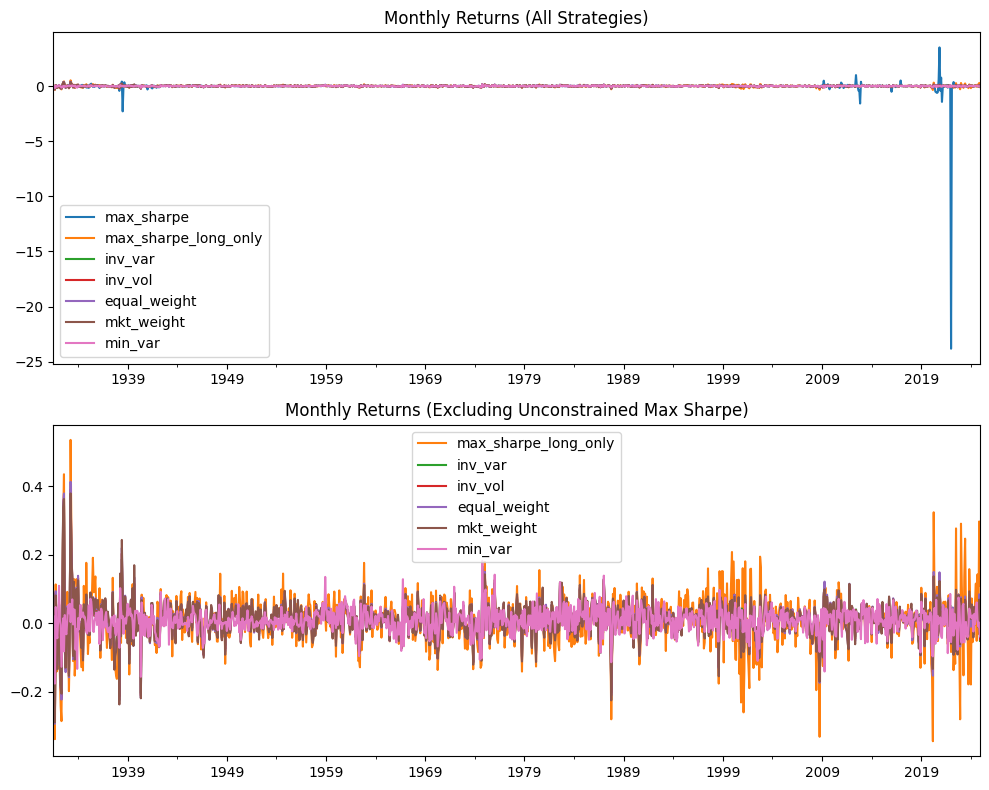

In [37]:
# plot monthly returns series
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

backtest.plot(ax=axes[0])
axes[0].set_title('Monthly Returns (All Strategies)')

backtest.drop('max_sharpe', axis=1).plot(ax=axes[1], color = list(mcolors.TABLEAU_COLORS.values())[1:7])
axes[1].set_title('Monthly Returns (Excluding Unconstrained Max Sharpe)')

plt.tight_layout()
plt.show()

In [ ]:
# compute cumulative returns
cum_returns = (1 + backtest).cumprod()

# Set all subsequent values to zero once a non-positive value for cumulative returns is encountered (since this represents bankruptcy)
for col in cum_returns.columns:
    non_positive_index = cum_returns[col].le(0).idxmax()
    if cum_returns[col].le(0).any():
        cum_returns.loc[non_positive_index:, col] = 0


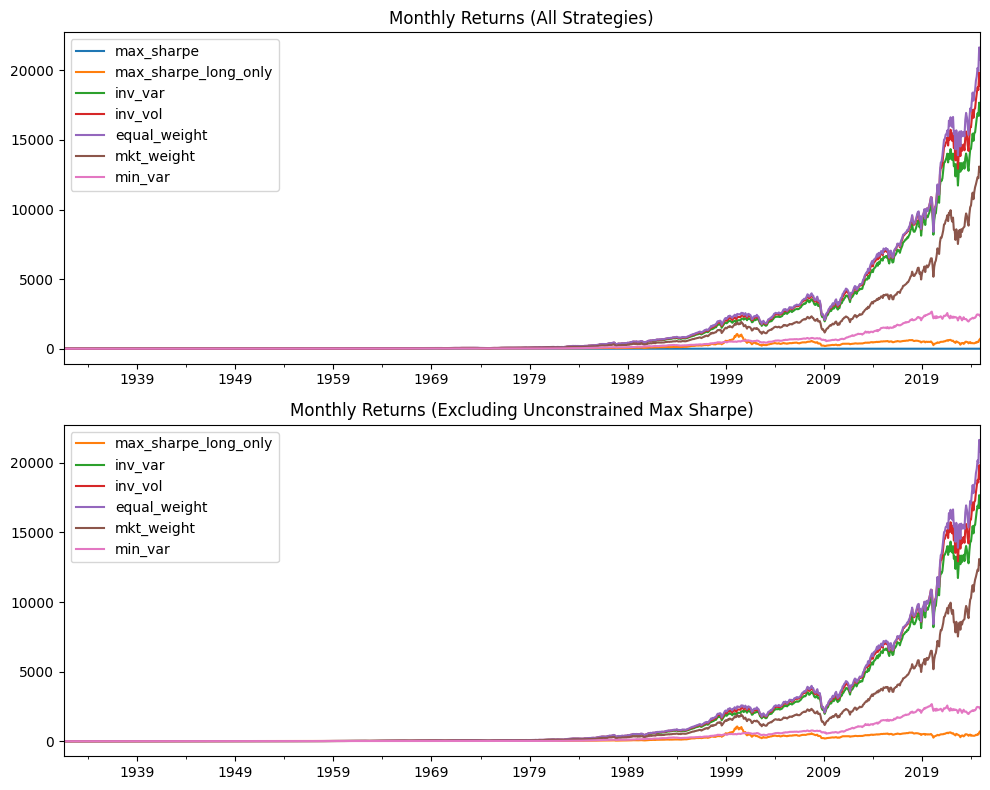

In [39]:

# plot cumulative returns series
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

cum_returns.plot(ax=axes[0])
axes[0].set_title('Monthly Returns (All Strategies)')

cum_returns.drop('max_sharpe', axis=1).plot(ax=axes[1], color = list(mcolors.TABLEAU_COLORS.values())[1:7])
axes[1].set_title('Monthly Returns (Excluding Unconstrained Max Sharpe)')

plt.tight_layout()
plt.show()

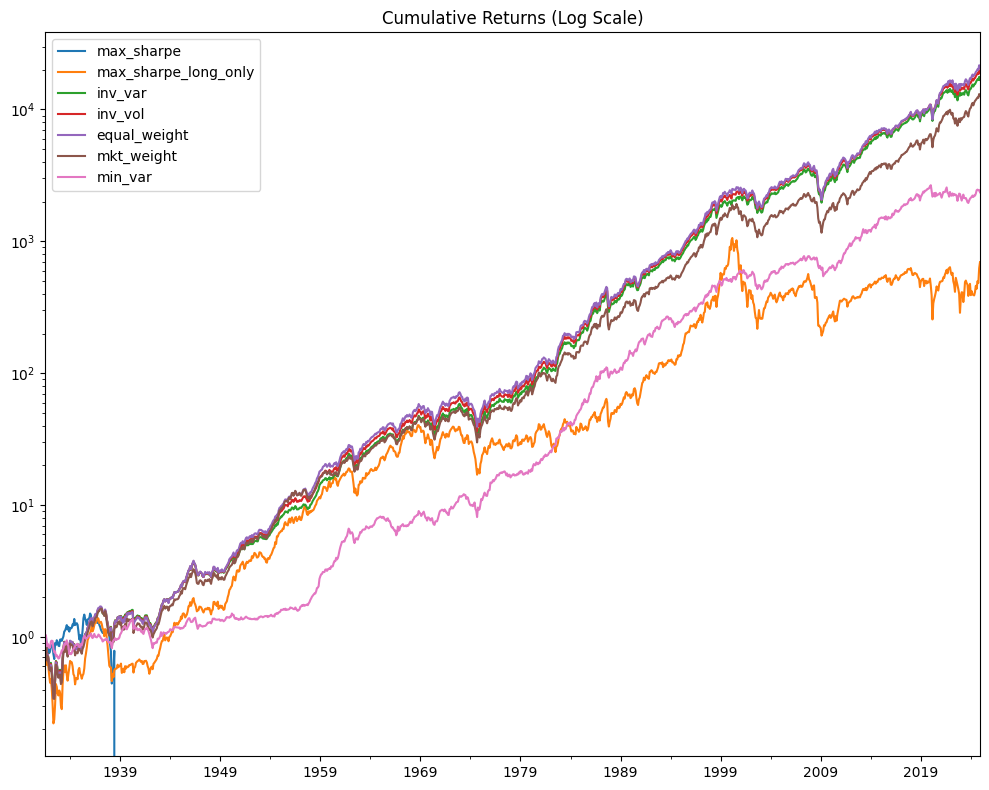

In [40]:
# plot cumulative log returns series
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

cum_returns.plot(ax = axes, color = list(mcolors.TABLEAU_COLORS.values())[0:7], logy = True)
axes.set_title('Cumulative Returns (Log Scale)')
plt.tight_layout()
plt.show()